In [ ]:
!pip install --quiet pillow

In [ ]:
pip install opendatasets #to download dataset directly in google colab

In [ ]:
import os
from PIL import Image, ImageFile

In [ ]:
import opendatasets as od

In [ ]:
od.download("https://www.kaggle.com/datasets/abdelghaniaaba/wildfire-prediction-dataset") #downloading dataset

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: 
Your Kaggle username: satyajitgarud
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/abdelghaniaaba/wildfire-prediction-dataset


100%|██████████| 1.45G/1.45G [00:16<00:00, 91.8MB/s]


In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, callbacks
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator


**Data Cleaning**: while training model I got error about corrupt data so deleting corrupt images from dataset

In [ ]:
def clean_corrupt_images(root_dir):
    total, removed = 0, 0
    for subdir, _, files in os.walk(root_dir):
        for fname in files:
            fpath = os.path.join(subdir, fname)
            # Only process common image extensions
            if not fname.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff')):
                continue
            total += 1
            try:
                # Quick integrity check (PNG chunk checksums, etc.)
                with Image.open(fpath) as img:
                    img.verify()
                # Full pixel data load to catch truncated files
                with Image.open(fpath) as img:
                    img.load()
            except Exception as e:
                # If either verify or load fails, delete the corrupt file
                print(f"Removing corrupt image: {fpath} – {e}")
                os.remove(fpath)
                removed += 1
    print(f"Scanned {total} images, removed {removed} corrupt files.")

In [ ]:
clean_corrupt_images('/content/wildfire-prediction-dataset')

Removing corrupt image: /content/wildfire-prediction-dataset/test/wildfire/-73.15884,46.38819.jpg – image file is truncated (51 bytes not processed)
Removing corrupt image: /content/wildfire-prediction-dataset/train/nowildfire/-114.152378,51.027198.jpg – image file is truncated (16 bytes not processed)
Scanned 42850 images, removed 2 corrupt files.


**Data Preprocessing** using ImageDataGenerator to rescale,rotate,shift,zoom,flip and reflect

In [ ]:
train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='reflect',
)
test = ImageDataGenerator(rescale=1/255)

In [ ]:
train_data = train.flow_from_directory(
    '/content/wildfire-prediction-dataset/train', #loading data from files
    target_size=(224,224),
    batch_size=64, # changes from 32 to 64 for speeding training
    class_mode='binary' #only 2 clases
)
valid_data = test.flow_from_directory(
    '/content/wildfire-prediction-dataset/valid',
    target_size=(224,224),
    batch_size=64,
    class_mode='binary'
)
test_data = test.flow_from_directory(
    '/content/wildfire-prediction-dataset/test',
    target_size=(224,224),
    batch_size=64,
    class_mode='binary',
    shuffle=False
)

Found 30249 images belonging to 2 classes.
Found 6300 images belonging to 2 classes.
Found 6299 images belonging to 2 classes.


In [ ]:
model = models.Sequential([
    # First convolutional block: learn 32 feature maps with 3×3 kernels
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    # Shrinking the image size by half(112*112) to focus on the strongest features
    layers.MaxPooling2D((2,2)),
    # Second convolutional block: increase to 64 feature maps
    layers.Conv2D(64, (3,3), activation='relu'),
    # Again shrink by half(56*56)
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu'),
    #final shrinking (28*28)
    layers.MaxPooling2D((2,2)),
    # 3D feature maps to 1D
    layers.Flatten(),
    # Basic ANN layer
    layers.Dense(256, activation='relu'),
    # to reduce overfitting
    layers.Dropout(0.5),
    #final output layer
    layers.Dense(1, activation='sigmoid'),# using sigmoid function because it is binary classification
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

In [ ]:
# Stop training if val_loss saturate for 4 epochs
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)


In [ ]:
history = model.fit(
    train_data,
    epochs=10, # 10 epoch for bigger data
    validation_data=valid_data,
    callbacks=[early_stop],
)

Epoch 1/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 444s 939ms/step - accuracy: 0.9621 - loss: 0.1062 - precision: 0.9601 - recall: 0.9678 - val_accuracy: 0.9619 - val_loss: 0.1043 - val_precision: 0.9833 - val_recall: 0.9471
Epoch 2/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 412s 870ms/step - accuracy: 0.9634 - loss: 0.1018 - precision: 0.9607 - recall: 0.9697 - val_accuracy: 0.9708 - val_loss: 0.0822 - val_precision: 0.9799 - val_recall: 0.9670
Epoch 3/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 414s 875ms/step - accuracy: 0.9623 - loss: 0.1026 - precision: 0.9587 - recall: 0.9696 - val_accuracy: 0.9759 - val_loss: 0.0735 - val_precision: 0.9790 - val_recall: 0.9773
Epoch 4/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 409s 863ms/step - accuracy: 0.9638 - loss: 0.0978 - precision: 0.9606 - recall: 0.9700 - val_accuracy: 0.9679 - val_loss: 0.1070 - val_precision: 0.9686 - val_recall: 0.9736
Epoch 5/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 412s 871ms/step - accuracy: 0.9650 - loss: 0.0953 - precision: 0.9614 - recall: 0.9720 - val_accuracy: 0

Text(0.5, 1.0, 'Loss')

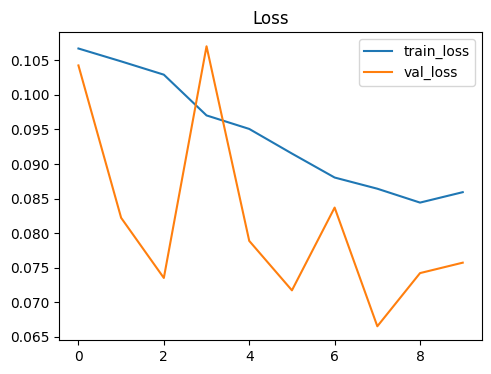

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Loss')

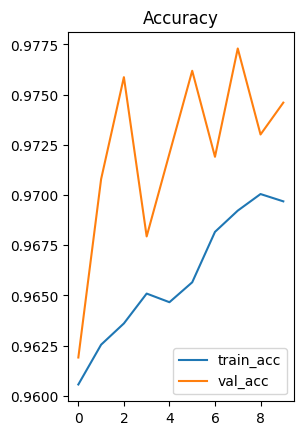

In [ ]:
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.title('Accuracy')
plt.show()

In [ ]:
test_loss, test_acc, test_prec, test_rec = model.evaluate(test_data, verbose=1)
print(f"Test Acc: {test_acc:.4f}, Prec: {test_prec:.4f}, Rec: {test_rec:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


99/99 ━━━━━━━━━━━━━━━━━━━━ 18s 180ms/step - accuracy: 0.9809 - loss: 0.0503 - precision: 0.5300 - recall: 0.5496
Test Acc: 0.9843, Prec: 0.9859, Rec: 0.9856


In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, auc

In [ ]:
y_true = test_data.classes
y_pred = (model.predict(test_data) > 0.5).astype(int).ravel()
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

99/99 ━━━━━━━━━━━━━━━━━━━━ 16s 163ms/step
Confusion Matrix:
 [[2771   49]
 [  50 3429]]


In [ ]:
y_score = model.predict(test_data).ravel()
fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

99/99 ━━━━━━━━━━━━━━━━━━━━ 17s 167ms/step


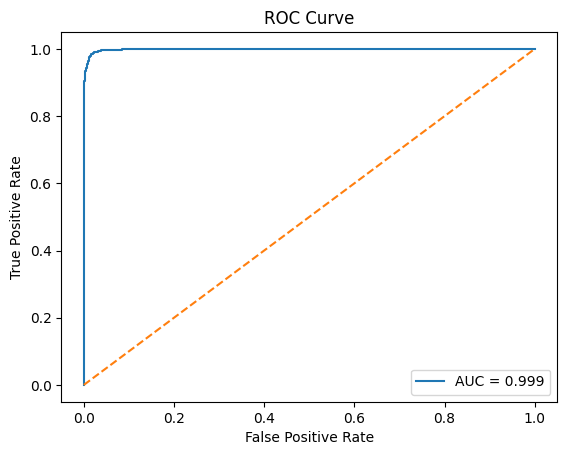

In [ ]:
plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
plt.plot([0,1],[0,1],'--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

**Pretrained Model: Resnet50**

In [ ]:
#using ResNet50 as pretrained model
from tensorflow.keras.applications import ResNet50

In [ ]:
base_model = ResNet50(
    weights='imagenet',
    include_top=False, # removing last layer
    input_shape=(224,224, 3)
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
#for not training ResNet again
base_model.trainable = False


In [31]:
#adding final layer over ResNet50
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(), # better than maxpooling in this case
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5), # for overfitting
    layers.Dense(1, activation='sigmoid'), # for binary classification
])

In [30]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

In [ ]:
model.summary() # overview of layers

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,112,513 (91.98 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
early_stop = callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

In [24]:
# training only custom layer
history = model.fit(
    train_data,
    epochs=10,
    validation_data=valid_data,
    callbacks=[early_stop]
)

Epoch 1/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 414s 874ms/step - accuracy: 0.8621 - loss: 0.3398 - precision: 0.8345 - recall: 0.9190 - val_accuracy: 0.8760 - val_loss: 0.2936 - val_precision: 0.8777 - val_recall: 0.9011
Epoch 2/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 403s 853ms/step - accuracy: 0.8672 - loss: 0.3247 - precision: 0.8375 - recall: 0.9227 - val_accuracy: 0.8744 - val_loss: 0.2945 - val_precision: 0.8808 - val_recall: 0.8937
Epoch 3/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 408s 863ms/step - accuracy: 0.8699 - loss: 0.3226 - precision: 0.8409 - recall: 0.9255 - val_accuracy: 0.8751 - val_loss: 0.2882 - val_precision: 0.8820 - val_recall: 0.8934
Epoch 4/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 413s 873ms/step - accuracy: 0.8682 - loss: 0.3276 - precision: 0.8402 - recall: 0.9227 - val_accuracy: 0.8695 - val_loss: 0.3103 - val_precision: 0.8909 - val_recall: 0.8704
Epoch 5/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 410s 867ms/step - accuracy: 0.8738 - loss: 0.3166 - precision: 0.8468 - recall: 0.9239 - val_accuracy: 0

In [26]:
test_loss, test_acc, test_prec, test_rec = model.evaluate(test_data, verbose=1)
print(f"Test Acc: {test_acc:.4f}, Prec: {test_prec:.4f}, Rec: {test_rec:.4f}")

99/99 ━━━━━━━━━━━━━━━━━━━━ 23s 230ms/step - accuracy: 0.8565 - loss: 0.3030 - precision: 0.4099 - recall: 0.5096
Test Acc: 0.8936, Prec: 0.8877, Rec: 0.9244


In [27]:
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc
y_true = test_data.classes
y_pred_prob = model.predict(test_data).ravel()
y_pred = (y_pred_prob > 0.5).astype(int)

99/99 ━━━━━━━━━━━━━━━━━━━━ 25s 220ms/step


In [28]:
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[2413  407]
 [ 263 3216]]


In [32]:
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

In [33]:
import matplotlib.pyplot as plt

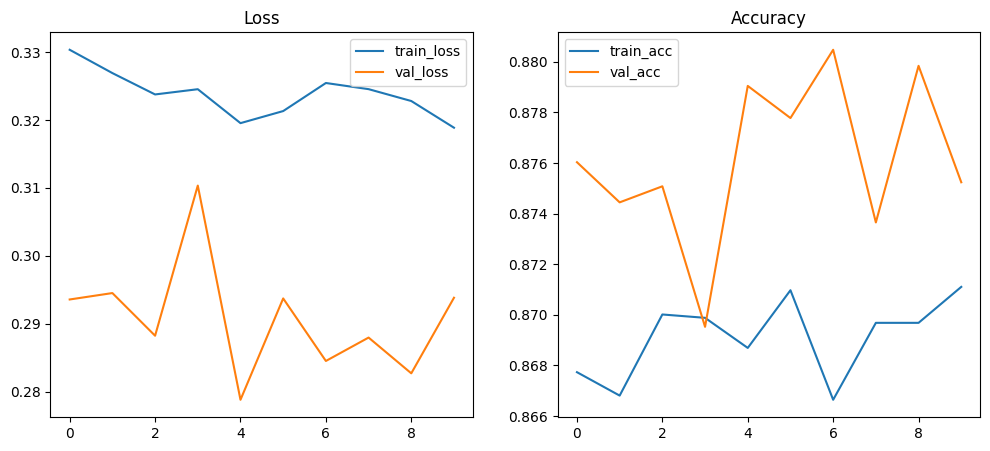

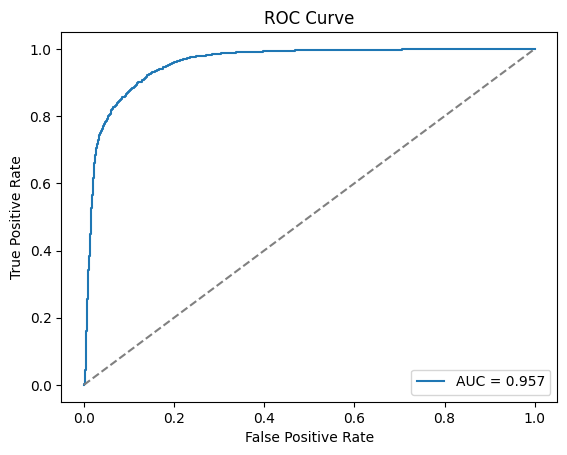

In [34]:
# Loss and Accuracy
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss'); plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Accuracy'); plt.legend()
plt.show()  #

# ROC Curve
plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
plt.plot([0,1], [0,1], '--', color='gray')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curve'); plt.legend()
plt.show()
